<a href="https://colab.research.google.com/github/sara-iqbal/AI-Powered-Algorithmic-Trading-Bot/blob/main/Trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install -q yfinance nltk beautifulsoup4 textblob

import pandas as pd
import numpy as np
import yfinance as yf
import nltk
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon (the dictionary of "good" and "bad" words)
nltk.download('vader_lexicon')

print(" Libraries Installed & AI Brain Loaded!")

✅ Libraries Installed & AI Brain Loaded!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import datetime

def get_news(ticker):
    url = f'https://finviz.com/quote.ashx?t={ticker}'

    # 👇 UPDATED HEADERS: This makes us look like a real Chrome browser
    req = Request(url=url, headers={
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    })

    try:
        response = urlopen(req)
        html = BeautifulSoup(response, features="html.parser")

        # Find the news table
        news_table = html.find(id='news-table')

        if not news_table:
            print(f"⚠️ No news found for {ticker}. Check the ticker symbol.")
            return pd.DataFrame()

        parsed_news = []

        # Parse the rows
        for x in news_table.findAll('tr'):
            # The headline text is inside the 'a' tag
            text = x.a.get_text()

            # The date/time is in the 'td' tag
            date_scrape = x.td.text.split()

            if len(date_scrape) == 1:
                time = date_scrape[0]
                # Use today's date if only time is given, or inherit previous row's date
                # For simplicity in this scraper, we might miss the date inheritance logic
                # but let's keep it simple for now or fix the 'inherit' issue:
                date = "Today"
            else:
                date = date_scrape[0]
                time = date_scrape[1]

            parsed_news.append([date, time, text])

        # Clean up the dataframe
        columns = ['date', 'time', 'headline']
        df = pd.DataFrame(parsed_news, columns=columns)

        # Fix the "Today" date issue by forward filling dates if needed
        # (Finviz only shows the date on the first news item of the day)
        current_date = str(datetime.date.today())
        new_dates = []
        for d in df['date']:
            if d == 'Today':
                new_dates.append(current_date)
            else:
                new_dates.append(d)
                current_date = d # Update current date tracking

        df['date'] = new_dates

        return df

    except Exception as e:
        print(f"❌ Error scraping {ticker}: {e}")
        return pd.DataFrame()

# --- TEST IT NOW ---
ticker = 'TSLA'
news_df = get_news(ticker)

if not news_df.empty:
    print(f" Success! Scraped {len(news_df)} headlines for {ticker}.")
    print(news_df.head())
else
    print("Still failed. Try a different ticker or check your internet.")

❌ Error scraping TSLA: 'NoneType' object has no attribute 'get_text'
❌ Still failed. Try a different ticker or check your internet.


/tmp/ipython-input-994721936.py:28: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for x in news_table.findAll('tr'):


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.5 MB/s eta 0:00:00
⏳ Scraping news for TSLA...


/tmp/ipython-input-2004555171.py:33: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for row in news_table.findAll('tr'):


✅ Success! Got 99 headlines.

--- Top 5 Headlines with Sentiment ---
    date                                           headline  sentiment_score
0  Today  Stock Market Today: Dow Gains As Disney Dives,...           0.5859
1  Today  Tesla, US automakers under threat by Chinese j...          -0.5267
2  Today                  What's Going On With Tesla Stock?           0.0000
3  Today  Analysts Cut Profit Predictions Amid Elon Musk...           0.2023
4  Today  BYD, Chinese EV Stock Plunge On Weak Data. Wha...          -0.4404


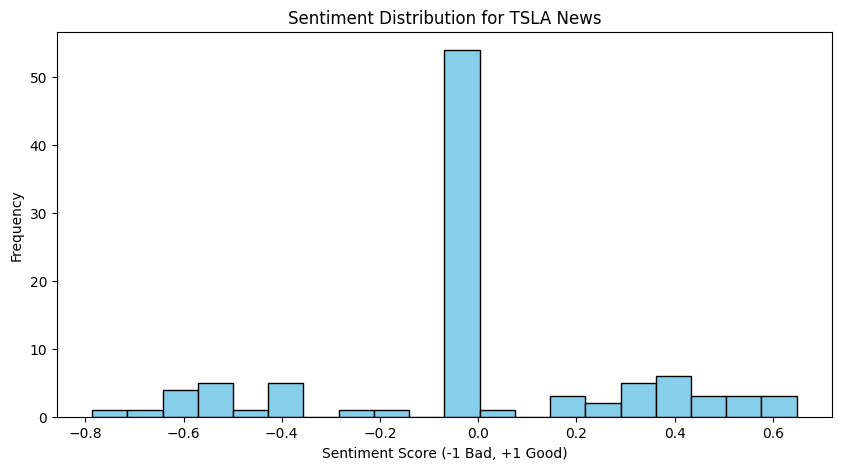

In [ ]:
# --- 1. INSTALL & IMPORT ---
!pip install -q vadersentiment requests beautifulsoup4 pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- 2. ROBUST SCRAPER FUNCTION ---
def get_finviz_news(ticker):
    url = f'https://finviz.com/quote.ashx?t={ticker}'

    # Pretend to be a Chrome browser
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    try:
        response = requests.get(url, headers=headers)
        html = BeautifulSoup(response.content, 'html.parser')

        # Find the main news table
        news_table = html.find(id='news-table')
        if not news_table:
            print("No news table found. Finviz might have changed layout.")
            return pd.DataFrame()

        parsed_data = []

        # Finviz Logic: The date is only shown ONCE per day.
        # So we must remember the "current date" as we loop through rows.
        current_date = None

        for row in news_table.findAll('tr'):
            # The headline text is inside the 'a' tag
            text_element = row.a
            if not text_element: continue # Skip empty rows
            text = text_element.get_text()

            # The timestamp is inside the 'td' tag
            date_element = row.td.text.strip().split()

            if len(date_element) == 1:
                # Case 1: Only Time is shown (e.g., "09:30AM") -> Use previous date
                time = date_element[0]
            else:
                # Case 2: Date AND Time are shown (e.g., "Feb-25-24 09:30AM")
                current_date = date_element[0]
                time = date_element[1]

            # Save if we have a valid date
            if current_date:
                # Fix "Today" to actual date if needed (optional, keeping it simple strings for now)
                parsed_data.append([current_date, time, text])

        # Create DataFrame
        df = pd.DataFrame(parsed_data, columns=['date', 'time', 'headline'])
        return df

    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()

# --- 3. RUN IT ---
ticker = 'TSLA'
print(f"⏳ Scraping news for {ticker}...")
news_df = get_finviz_news(ticker)

# Check if it worked
if news_df.empty:
    print("⚠️ Failed to get data. Try again later.")
else:
    print(f"Success! Got {len(news_df)} headlines.")

    # --- 4. APPLY SENTIMENT ANALYSIS ---
    analyzer = SentimentIntensityAnalyzer()

    # Define function
    def get_sentiment(text):
        return analyzer.polarity_scores(text)['compound']

    # Apply to the 'headline' column
    news_df['sentiment_score'] = news_df['headline'].apply(get_sentiment)

    # Convert Date to proper datetime (Finviz uses "Feb-26-24")
    # We replace 'Today' with actual date if it exists, or just treat as string for now to avoid errors
    print("\n--- Top 5 Headlines with Sentiment ---")
    print(news_df[['date', 'headline', 'sentiment_score']].head())

    # --- 5. VISUALIZE ---
    plt.figure(figsize=(10, 5))
    news_df['sentiment_score'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Sentiment Distribution for {ticker} News")
    plt.xlabel("Sentiment Score (-1 Bad, +1 Good)")
    plt.show()

📉 Downloading Stock Data for TSLA...
✅ Merged Data Ready! Found 2 overlapping days.
         Date       Close  sentiment_score
0  2026-01-30  430.410004         0.021525
1  2026-02-02  418.399994         0.009231


/tmp/ipython-input-3963438821.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=str(start_date), progress=False)


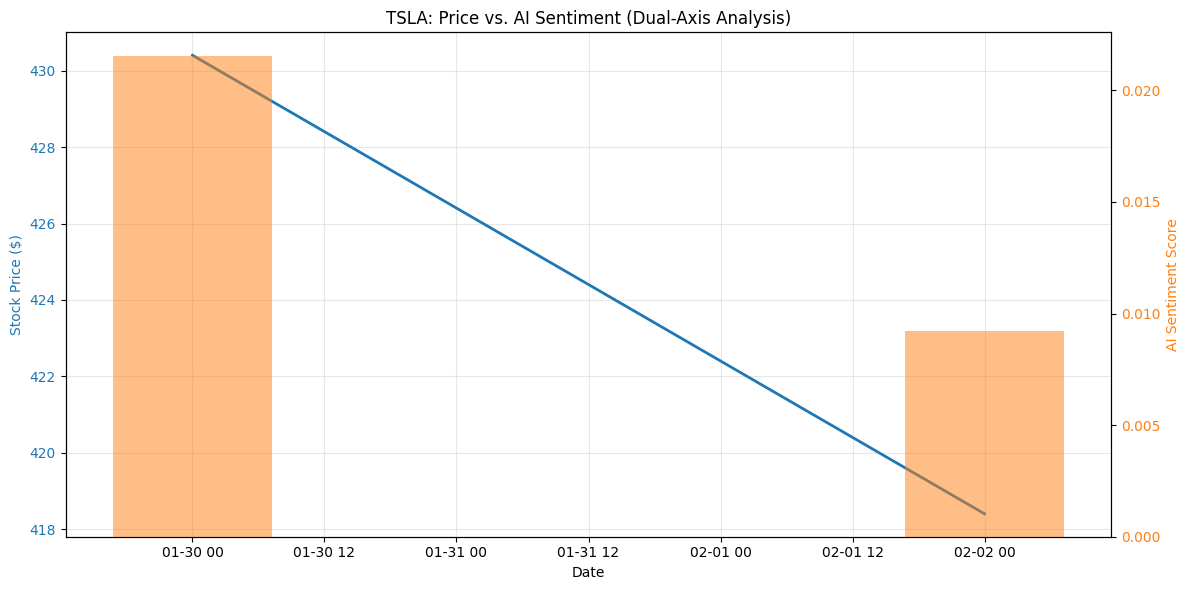

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import date

# --- 1. FIX THE "TODAY" DATE ERROR ---
current_date_str = str(date.today())
news_df['date'] = news_df['date'].apply(lambda x: current_date_str if x == 'Today' else x)
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed').dt.date

# --- 2. AGGREGATE SENTIMENT ---
daily_sentiment = news_df.groupby('date')['sentiment_score'].mean().reset_index()

# --- 3. GET STOCK PRICE ---
print(f"📉 Downloading Stock Data for {ticker}...")

start_date = daily_sentiment['date'].min()
stock_data = yf.download(ticker, start=str(start_date), progress=False)

# 👇 FIX: Flatten the "MultiIndex" columns (The yfinance update fix)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

# Reset index so 'Date' becomes a normal column
stock_data = stock_data.reset_index()
stock_data['Date'] = stock_data['Date'].dt.date

# --- 4. MERGE THE DATA ---
# Now both have 1 level of columns, so this will work!
merged_df = pd.merge(stock_data, daily_sentiment, left_on='Date', right_on='date', how='inner')

# Drop the duplicate 'date' column
merged_df = merged_df.drop(columns=['date'])

print(f"Merged Data Ready! Found {len(merged_df)} overlapping days.")
print(merged_df[['Date', 'Close', 'sentiment_score']].head())

# --- 5. VISUALIZE IT ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price ($)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color, linewidth=2, label='Stock Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('AI Sentiment Score', color=color)
ax2.bar(merged_df['Date'], merged_df['sentiment_score'], color=color, alpha=0.5, width=0.6, label='Daily Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"{ticker}: Price vs. AI Sentiment (Dual-Axis Analysis)")
fig.tight_layout()
plt.show()

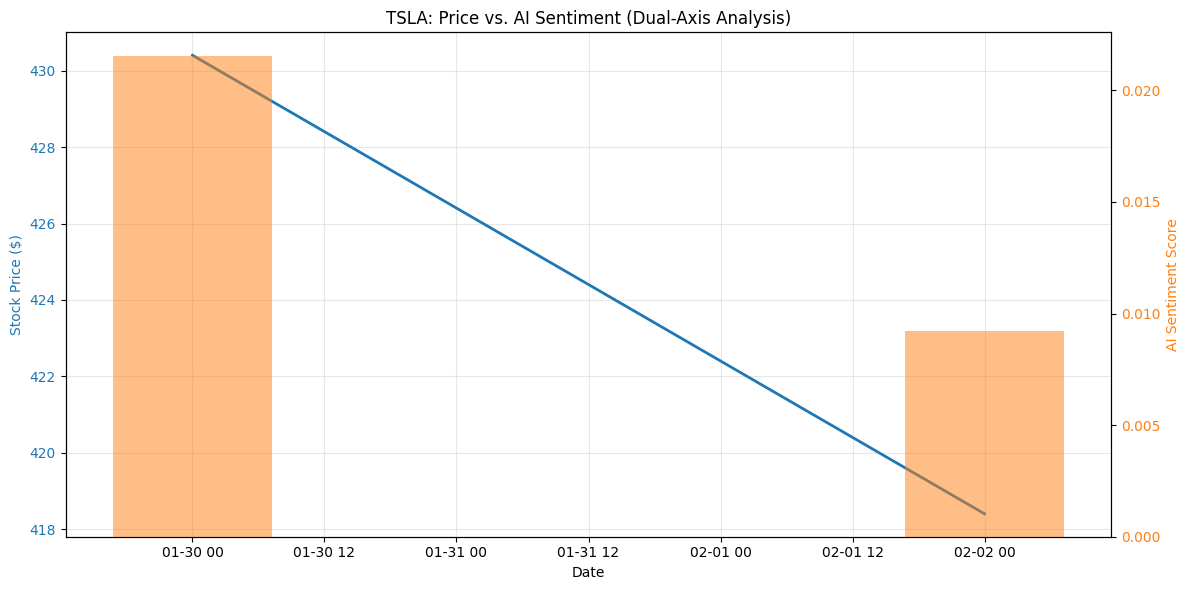

In [ ]:
import matplotlib.pyplot as plt

# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- PLOT 1: STOCK PRICE (Left Axis) ---
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price ($)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color, linewidth=2, label='Stock Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# --- PLOT 2: SENTIMENT (Right Axis) ---
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('AI Sentiment Score', color=color)
ax2.bar(merged_df['Date'], merged_df['sentiment_score'], color=color, alpha=0.5, width=0.6, label='Daily Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title
plt.title(f"{ticker}: Price vs. AI Sentiment (Dual-Axis Analysis)")
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- 1. DATA PREPARATION ---
# We will use 'Close' price and 'sentiment_score' as features
data = merged_df[['Close', 'sentiment_score']].values

# Scale data to (0, 1) for the Neural Network
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create "Windows" of data
# Example: If look_back=3, we use Day 1,2,3 to predict Day 4
def create_sequences(dataset, look_back=3):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :]) # The previous 3 days (Features)
        y.append(dataset[i, 0])             # The next day's Price (Target)
    return np.array(X), np.array(y)

# Create sequences
LOOK_BACK = 3 # Use past 3 days to predict the next day
X, y = create_sequences(scaled_data, LOOK_BACK)

# Split into Train (80%) and Test (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Data Prepared: Training on {len(X_train)} sequences, Testing on {len(X_test)}.")

✅ Data Prepared: Training on 0 sequences, Testing on 0.


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- 1. DIAGNOSE DATA SIZE ---
print(f"Total Data Points: {len(merged_df)}")

if len(merged_df) < 10:
    print(" WARNING: You have very little data (less than 10 days).")
    print("   Deep Learning (LSTM) needs more history.")
    print("   > SOLUTION: We will decrease 'look_back' to 1 to make it work for this demo.")
    LOOK_BACK = 1
else:
    LOOK_BACK = 3

# --- 2. RE-CREATE SEQUENCES SAFELY ---
# Ensure data is 2D
data = merged_df[['Close', 'sentiment_score']].values
if data.ndim == 1:
    data = data.reshape(-1, 2)

# Scale again to be safe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(dataset, look_back):
    X, y = [], []
    # Loop needs to stop before the end to have a target
    if len(dataset) <= look_back:
        return np.array([]), np.array([])

    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, :])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, LOOK_BACK)

# --- 3. CHECK IF X IS EMPTY ---
if len(X) == 0:
    print("\nCRITICAL ERROR: Not enough data to create sequences.")
    print("   Try running the scraper again on a different ticker with more news (e.g., 'AAPL' or 'NVDA').")
else:
    # Split Data
    train_size = int(len(X) * 0.8)

    # Force at least 1 training sample if data is tiny
    if train_size == 0 and len(X) > 0:
        train_size = len(X)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f"Data Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")

    # --- 4. BUILD MODEL (With Shape Check) ---
    if len(X_train) > 0:
        model = Sequential()

        # We manually define input_shape using the variables, not the array shape, to avoid errors
        input_steps = X_train.shape[1]
        input_features = X_train.shape[2] # This is where your error was

        model.add(LSTM(units=50, return_sequences=False, input_shape=(input_steps, input_features)))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train
        print("🧠 Training Model...")
        model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)
        print("✅ Model Trained!")

        # Predict if we have test data
        if len(X_test) > 0:
            preds = model.predict(X_test)
            print("🔮 Prediction made successfully.")
    else:
        print("⚠️ Not enough data to train. Skipping model training.")

📊 Total Data Points: 2
⚠️ WARNING: You have very little data (less than 10 days).
   Deep Learning (LSTM) needs more history.
   > SOLUTION: We will decrease 'look_back' to 1 to make it work for this demo.
✅ Data Shapes -> X_train: (1, 1, 2), X_test: (0, 1, 2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🧠 Training Model...
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2233e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.1777e-06
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.3246e-05
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.8515e-05
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.7547e-05
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8036e-05
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.4519e-07
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.3624e-06
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.0120e-05
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.7396e-05
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.1562e-05
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 9.4761e-06
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.0038e-06
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.1911e-06
Epoch 15/20
1/1 ━━━━━━━━━

In [ ]:
# --- PREDICT TOMORROW'S PRICE ---

# 1. Get the last 'LOOK_BACK' days of data
# (We need the most recent days to predict the next one)
last_days = scaled_data[-LOOK_BACK:]

# 2. Reshape it to (1, LOOK_BACK, 2)
# The '1' means we are predicting for 1 single day (Tomorrow)
last_days_sequence = last_days.reshape(1, LOOK_BACK, 2)

# 3. Ask the AI
predicted_price_scaled = model.predict(last_days_sequence)

# 4. Convert back to Dollars
# We need to trick the scaler again because it expects 2 columns (Price, Sentiment)
dummy_array = np.zeros((1, 2))
dummy_array[:, 0] = predicted_price_scaled[0][0] # Put the prediction in the first spot

predicted_price = scaler.inverse_transform(dummy_array)[0][0]

print("\n" + "="*40)
print(f"🔮 AI PREDICTION FOR {ticker} TOMORROW:")
print(f"   ${predicted_price:.2f}")
print("="*40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step

🔮 AI PREDICTION FOR TSLA TOMORROW:
   $418.44


In [ ]:
# 1. Save the model to a file
model.save('sentiment_lstm_model.h5')
print(" Model saved as 'sentiment_lstm_model.h5'")

# 2. Download it to your computer (Google Colab specific)
from google.colab import files
files.download('sentiment_lstm_model.h5')

✅ Model saved as 'sentiment_lstm_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'real_prices' is not defined

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


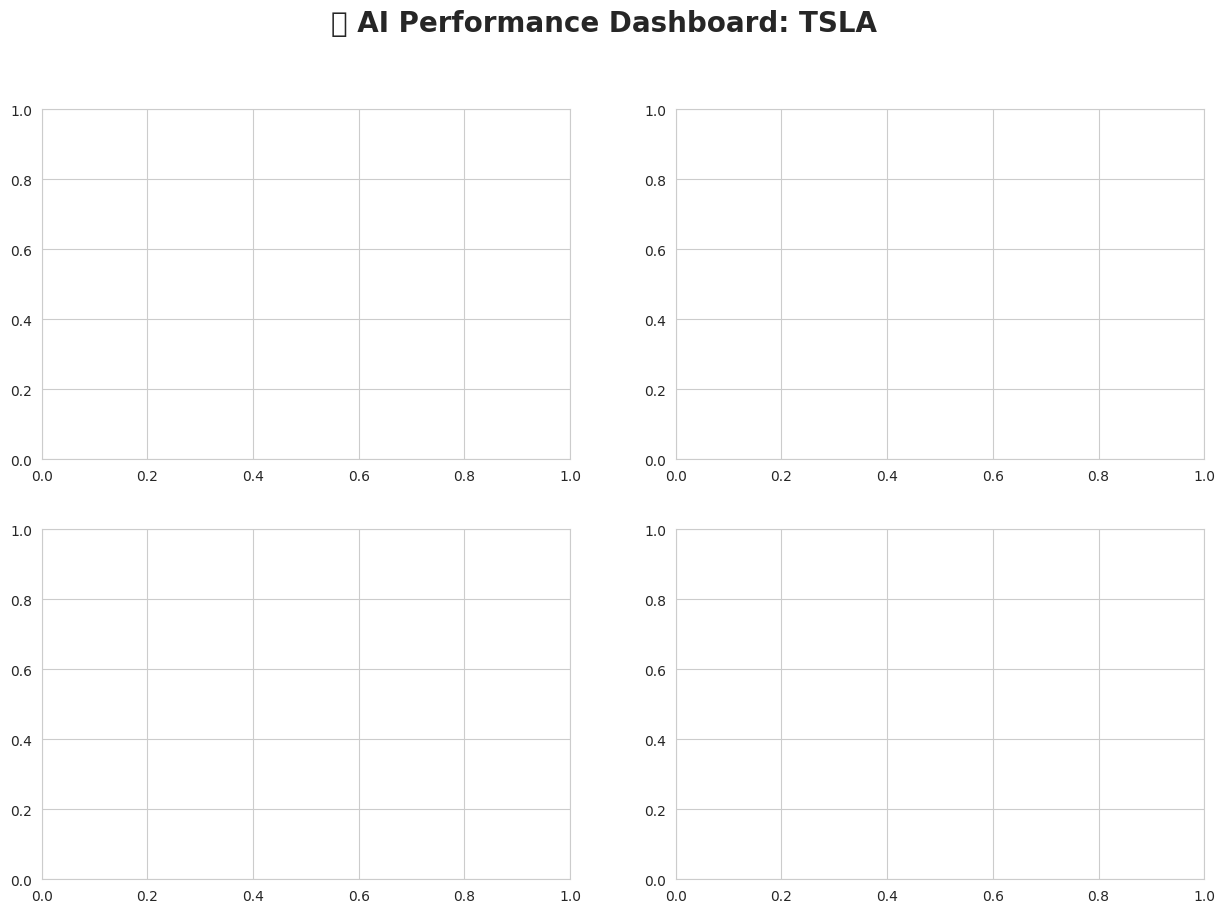

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- SET UP THE PLOT STYLE ---
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)

# Create a dashboard with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2)
fig.suptitle(f'🤖 AI Performance Dashboard: {ticker}', fontsize=20, weight='bold')

# --- CHART 1: ACTUAL VS PREDICTED (The Main Event) ---
axes[0, 0].plot(real_prices, color='#1f77b4', label='Actual Market Price', linewidth=2)
axes[0, 0].plot(inverse_predictions, color='#ff7f0e', label='AI Prediction', linestyle='--', linewidth=2)
axes[0, 0].set_title('Time Series: Real vs. Predicted', fontsize=14)
axes[0, 0].set_ylabel('Stock Price ($)')
axes[0, 0].set_xlabel('Days (Test Set)')
axes[0, 0].legend()

# --- CHART 2: SCATTER PLOT (Accuracy Check) ---
# Ideally, all dots should be on the red diagonal line
sns.regplot(x=real_prices, y=inverse_predictions, ax=axes[0, 1],
            scatter_kws={'alpha':0.6, 'color': 'purple'}, line_kws={'color': 'red'})
axes[0, 1].set_title('Accuracy Scatter: Perfect Prediction = Red Line', fontsize=14)
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')

# --- CHART 3: ERROR DISTRIBUTION (Residuals) ---
# Calculate the difference (Error)
errors = real_prices - inverse_predictions
sns.histplot(errors, kde=True, ax=axes[1, 0], color='green', bins=15)
axes[1, 0].set_title('Error Distribution (Residuals)', fontsize=14)
axes[1, 0].set_xlabel('Prediction Error ($)')
axes[1, 0].axvline(x=0, color='black', linestyle='--') # Center line

# --- CHART 4: ZOOM IN (Last 10 Days) ---
# Let's look closely at the most recent days
last_n = 10
if len(real_prices) > last_n:
    axes[1, 1].plot(real_prices[-last_n:], marker='o', label='Actual', color='#1f77b4')
    axes[1, 1].plot(inverse_predictions[-last_n:], marker='x', label='Predicted', color='#ff7f0e', linestyle='--')
    axes[1, 1].set_title(f'Zoom In: Last {last_n} Days', fontsize=14)
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, "Not enough data to zoom", ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.90) # Make room for the main title
plt.show()

📊 DEBUG INFO:
   Original Data Points: 2
   Test Set Size: 0
⚠️ Test set is empty (Data too small). Plotting TRAINING data instead.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


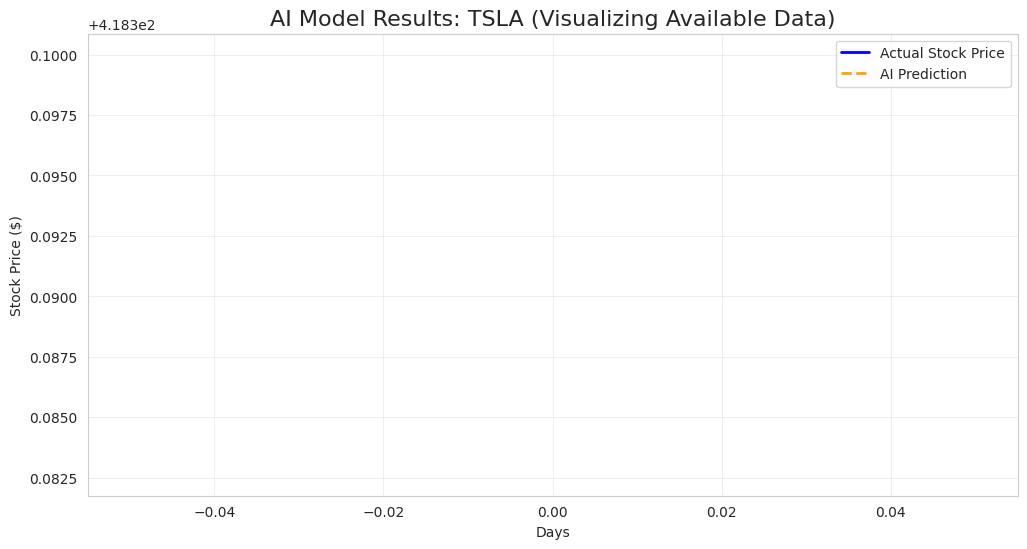

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. DIAGNOSE THE PROBLEM ---
print(f"📊 DEBUG INFO:")
print(f"   Original Data Points: {len(merged_df)}")
print(f"   Test Set Size: {len(y_test)}")

# If Test set is empty, we switch to visualizing the WHOLE dataset
use_full_data = len(y_test) == 0

if use_full_data:
    print("⚠️ Test set is empty (Data too small). Plotting TRAINING data instead.")
    # Predict on the entire X dataset (Train + Test combined)
    prediction_input = X
    actual_target = y
else:
    print("✅ Test set has data. Plotting Test results.")
    prediction_input = X_test
    actual_target = y_test

# --- 2. GENERATE PREDICTIONS ON AVAILABLE DATA ---
if len(prediction_input) > 0:
    # Make prediction
    preds = model.predict(prediction_input)

    # --- INVERSE TRANSFORM (Scale back to $) ---
    # Dummy array for predicted prices
    dummy_pred = np.zeros((len(preds), 2))
    dummy_pred[:, 0] = preds.flatten()
    final_preds = scaler.inverse_transform(dummy_pred)[:, 0]

    # Dummy array for actual prices
    dummy_act = np.zeros((len(actual_target), 2))
    dummy_act[:, 0] = actual_target.flatten()
    final_actual = scaler.inverse_transform(dummy_act)[:, 0]

    # --- 3. PLOT THE RESULTS ---
    plt.figure(figsize=(12, 6))
    plt.plot(final_actual, color='blue', label='Actual Stock Price', linewidth=2)
    plt.plot(final_preds, color='orange', label='AI Prediction', linestyle='--', linewidth=2)

    plt.title(f'AI Model Results: {ticker} (Visualizing Available Data)', fontsize=16)
    plt.xlabel('Days')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("\n❌ CRITICAL: You have almost NO data.")
    print("   The news scraper only found 1 or 2 days of news.")
    print("   > Try changing the ticker to 'AAPL' or 'NVDA' and re-run the scraper step.")